In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats import proportion, power

In [6]:
df = pd.read_csv('cookie_cats.csv')

# читаем первые 5 строк
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Анализ данных

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [8]:
#уникальные игроки
df["userid"].nunique()

90189

In [9]:
#уникальные игроки в каждой группе
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


In [10]:
#есть ли дубликаты
df.duplicated(subset=["userid"]).any()

False

In [11]:
# % игроков, кто вернулся после установки игры
df["retention_1"].mean()

0.4452095044850259

In [12]:
# разница в одновневном удержании между группами
df.groupby("version")["retention_1"].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

In [13]:
# разница в семидневном удержании между группами
df.groupby("version")["retention_7"].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

In [14]:
# поменяем true & false на 1 и 0
df["retention_1"] = df["retention_1"].replace({True: 1, False: 0})
df["retention_7"] = df["retention_7"].replace({True: 1, False: 0})

In [15]:
# есть ли выбросы?
df["sum_gamerounds"].sort_values(ascending=False).head()

57702    49854
7912      2961
29417     2640
43671     2438
48188     2294
Name: sum_gamerounds, dtype: int64

есть выброс. 49854 игр против ~3000

In [16]:
# предлагаю удалить выбросы
df = df[df["sum_gamerounds"] < 3000].reset_index()

Text(0, 0.5, 'number of players')

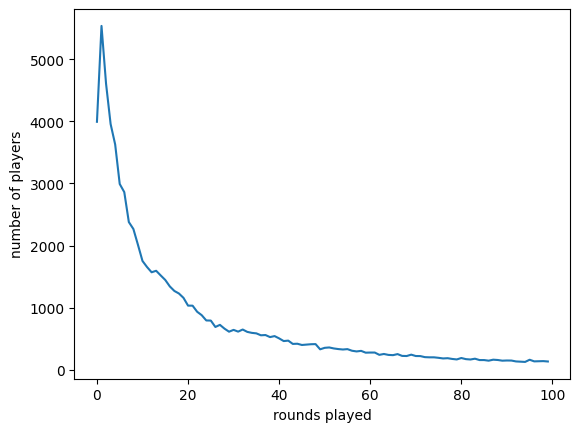

In [17]:
# распределение игровых раундов

plot_df = df.groupby("sum_gamerounds")["userid"].count()

ax = plot_df.head(100).plot()
ax.set_xlabel("rounds played")
ax.set_ylabel("number of players")

In [18]:
# смотрим на распределение игровых раундов в цифрах
df["sum_gamerounds"].value_counts().sort_index().head()

sum_gamerounds
0    3994
1    5538
2    4606
3    3958
4    3629
Name: count, dtype: int64

3994 игрока не играли в эту игру. Так как нам надо проверить удержание игроков, нам эти данные мешают

In [19]:
# удаляем не игравших игроков
df = df[df["sum_gamerounds"] != 0].reset_index()

In [20]:
# уровень удержания по группам
retention_rate = df.groupby("version").agg({"userid":"count", "retention_1":"mean", "retention_7":"mean"})
retention_rate

,userid,retention_1,retention_7
version,,,
gate_30,42762,0.467541,0.198424
gate_40,43432,0.462171,0.190321


In [21]:
# разница между группами
ret1_diff = (retention_rate.loc["gate_30"]["retention_1"] - retention_rate.loc["gate_40"]["retention_1"]) / retention_rate.loc["gate_40"]["retention_1"]
ret7_diff = (retention_rate.loc["gate_30"]["retention_7"] - retention_rate.loc["gate_40"]["retention_7"]) / retention_rate.loc["gate_40"]["retention_7"]
ret1_diff, ret7_diff

(0.011620218912255967, 0.042577300864310504)

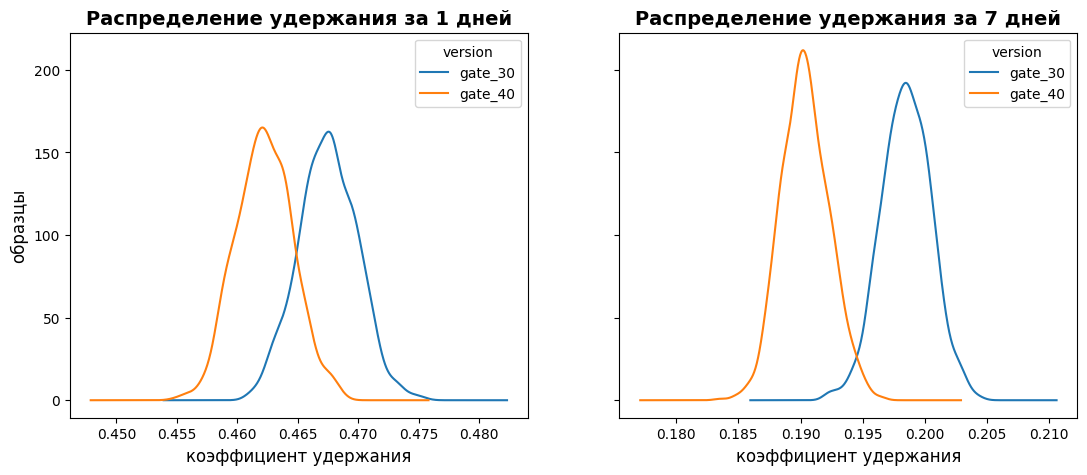

In [24]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

bootstrap_1d = pd.DataFrame([df.sample(frac=1, replace=True).groupby("version")["retention_1"].mean() for i in range(1000)])
bootstrap_7d = pd.DataFrame([df.sample(frac=1, replace=True).groupby("version")["retention_7"].mean() for i in range(1000)])

bootstrap_1d.plot.kde(ax=ax1)
ax1.set_xlabel("коэффициент удержания", size=12)
ax1.set_ylabel("образцы", size=12)
ax1.set_title("Распределение удержания за 1 дней", fontweight="bold", size=14)

bootstrap_7d.plot.kde(ax=ax2)
ax2.set_xlabel("коэффициент удержания", size=12)
ax2.set_title("Распределение удержания за 7 дней", fontweight="bold", size=14)
plt.show()

Тестирование 1-дневного удержания

In [25]:
group_a = df[df["version"] == "gate_30"]
group_b = df[df["version"] == "gate_40"]

In [26]:
k1 = group_a["retention_1"].sum()
k2 = group_b["retention_1"].sum()
k1, k2

(19993, 20073)

In [27]:
n1 = group_a.shape[0]
n2 = group_b.shape[0]
n1, n2

(42762, 43432)

In [28]:
z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), np.array([n1, n2]))
print("Results are ","z_score = %.3f, pvalue = %.3f"%(z_score, z_pvalue))

Results are  z_score = 1.581, pvalue = 0.114


In [29]:
if abs(z_pvalue) < 0.05:
    print("Reject the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

Failed to reject the null hypothesis


хи-квадрат

In [30]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), np.array([n1, n2]))
print("Results are", "chisq = %.3f, pvalue = %.3f"%(chisq, pvalue))

Results are chisq = 2.498, pvalue = 0.114


In [31]:
if abs(pvalue) < 0.05:
    print("Reject the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

Failed to reject the null hypothesis


по полученным результатам мы можем сделать вывод, что между группами нет значимой разницы


проверим семидневное удержание

In [32]:
k1 = group_a["retention_7"].sum()
k2 = group_b["retention_7"].sum()
k1, k2

(8485, 8266)

In [33]:
n1 = group_a.shape[0]
n2 = group_b.shape[0]
n1, n2

(42762, 43432)

In [34]:
z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), np.array([n1, n2]))
print("Results are ","z_score = %.3f, pvalue = %.3f"%(z_score, z_pvalue))

Results are  z_score = 3.006, pvalue = 0.003


In [35]:
if abs(z_pvalue) < 0.05:
    print("Reject the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

Reject the null hypothesis


In [36]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), np.array([n1, n2]))
print("Results are", "chisq = %.3f, pvalue = %.3f"%(chisq, pvalue))

Results are chisq = 9.037, pvalue = 0.003


In [37]:
if abs(pvalue) < 0.05:
    print("Reject the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

Reject the null hypothesis


Мы можем утверждать, что существует статистически значимая разница между двумя группами по показателю удержания

In [38]:
effect_size = proportion.proportion_effectsize(k1/n1, k2/n2)
effect_size

0.020478615862649874

In [39]:
power_val = power.zt_ind_solve_power(effect_size=effect_size, nobs1=n1, alpha=0.05, alternative="two-sided")
power_val

0.8495418952891222

Мощность теста высока > 0,8, у нас достаточно большой размер выборки, чтобы доверять статистическим результатам, полученным выше.

## Выводы:

1. Удержание на 1-й день:

Z-тест для пропорций:

Z-статистика (z_score) равна 1.581.
P-значение (z_pvalue) равно 0.114.
Вывод: Не удалось отвергнуть нулевую гипотезу.
Хи-квадрат тест для пропорций:

Значение хи-квадрата (chisq) равно 2.498.
P-значение (pvalue) также равно 0.114.
Вывод: Не удалось отвергнуть нулевую гипотезу.
Оба теста для удержания на 1-й день показывают, что нет статистически значимых различий между двумя группами.

2. Удержание на 7-й день:

Z-тест для пропорций:

Z-статистика (z_score) равна 3.006.
P-значение (z_pvalue) равно 0.003.
Вывод: Отвергнута нулевая гипотеза.

Хи-квадрат тест для пропорций:

Значение хи-квадрата (chisq) равно 9.037.
P-значение (pvalue) также равно 0.003.
Вывод: Отвергнута нулевая гипотеза.
Оба теста для удержания на 7-й день показывают статистически значимые различия между двумя группами.

Мощность теста:

Размер эффекта (effect_size) равен 0.0205.
Мощность теста (power_val) равна 0.8495.
Мощность теста указывает на способность теста обнаружить наличие эффекта, если таковой действительно существует. В данном случае, мощность теста довольно высокая (близка к 0.85), что говорит о хорошей способности теста обнаруживать различия при заданном уровне значимости.

Общий вывод:

Нет статистически значимых различий в удержании на 1-й день между двумя группами.
Есть статистически значимые различия в удержании на 7-й день между двумя группами, при этом группа с воротами на уровне 30 имеет более высокий показатель удержания на 7-й день.
Можно дать рекомендацию не изменять уровень ворот